In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
import matplotlib.pyplot as plt
import cv2

In [2]:
data_dir = '/content/drive/MyDrive/cancer_png'

In [3]:
Image_size = 256
Batch_size = 32
epochs = 10
channels = 3



In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    shuffle =True,
    seed = True,
    image_size =(Image_size,Image_size),
    batch_size = Batch_size

)

Found 977 files belonging to 2 classes.


In [5]:
import os
class_names = os.listdir(data_dir)

In [6]:
data_iteration = dataset.as_numpy_iterator()

In [7]:
batcha = data_iteration.next()

In [8]:
batcha

(array([[[[38.  , 38.  , 38.  ],
          [38.  , 38.  , 38.  ],
          [38.  , 38.  , 38.  ],
          ...,
          [38.  , 38.  , 38.  ],
          [38.  , 38.  , 38.  ],
          [38.  , 38.  , 38.  ]],
 
         [[38.  , 38.  , 38.  ],
          [38.  , 38.  , 38.  ],
          [38.  , 38.  , 38.  ],
          ...,
          [38.  , 38.  , 38.  ],
          [38.  , 38.  , 38.  ],
          [38.  , 38.  , 38.  ]],
 
         [[38.  , 38.  , 38.  ],
          [38.  , 38.  , 38.  ],
          [38.  , 38.  , 38.  ],
          ...,
          [38.  , 38.  , 38.  ],
          [38.  , 38.  , 38.  ],
          [38.  , 38.  , 38.  ]],
 
         ...,
 
         [[38.  , 38.  , 38.  ],
          [38.  , 38.  , 38.  ],
          [38.  , 38.  , 38.  ],
          ...,
          [38.  , 38.  , 38.  ],
          [38.  , 38.  , 38.  ],
          [38.  , 38.  , 38.  ]],
 
         [[38.  , 38.  , 38.  ],
          [38.  , 38.  , 38.  ],
          [38.  , 38.  , 38.  ],
          ...,
      

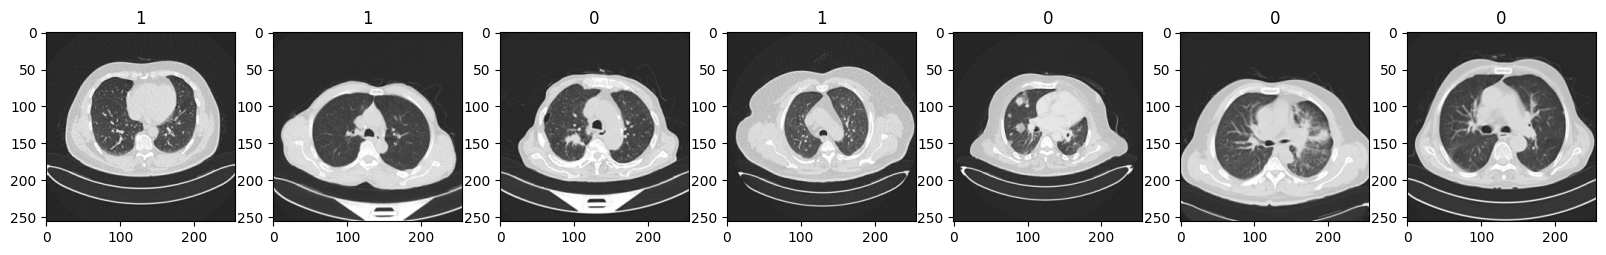

In [9]:
fig, ax = plt.subplots (ncols=7, figsize=(20,20))
for idx, img in enumerate(batcha[0][:7]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batcha[1][idx])

In [10]:
len(dataset)

31

In [11]:
train_size =0.8
len(dataset)* train_size

24.8

In [14]:
train_ds = dataset.take(24)
len(train_ds)

24

In [16]:
test_ds = dataset.skip(24)
len(test_ds)

7

In [17]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [18]:
test_ds = test_ds.skip(6)
len(test_ds)

1

In [19]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [20]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [22]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
resize_and_rescale = tf.keras.Sequential([
   layers.experimental.preprocessing.Resizing(Image_size,Image_size),
   layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [24]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [25]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:
input_shape = (Batch_size,Image_size,Image_size,channels)
n_classes=2

model =models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')

])
model.build(input_shape=input_shape)

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [28]:
model.compile(
    optimizer='adam',
    loss =tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [31]:
history = model.fit(
    train_ds,
    batch_size=Batch_size,
    validation_data=val_ds,
    verbose=1,
    epochs=11,
)

Epoch 1/11
24/24 [==============================] - 7s 289ms/step - loss: 0.4814 - accuracy: 0.7656 - val_loss: 0.4617 - val_accuracy: 0.8229
Epoch 2/11
24/24 [==============================] - 7s 304ms/step - loss: 0.4660 - accuracy: 0.7734 - val_loss: 0.4430 - val_accuracy: 0.7917
Epoch 3/11
24/24 [==============================] - 7s 298ms/step - loss: 0.4623 - accuracy: 0.7734 - val_loss: 0.4698 - val_accuracy: 0.8021
Epoch 4/11
24/24 [==============================] - 7s 278ms/step - loss: 0.4342 - accuracy: 0.7891 - val_loss: 0.4407 - val_accuracy: 0.7917
Epoch 5/11
24/24 [==============================] - 7s 304ms/step - loss: 0.4113 - accuracy: 0.8255 - val_loss: 0.5242 - val_accuracy: 0.7396
Epoch 6/11
24/24 [==============================] - 7s 279ms/step - loss: 0.4016 - accuracy: 0.8294 - val_loss: 0.3866 - val_accuracy: 0.7708
Epoch 7/11
24/24 [==============================] - 7s 281ms/step - loss: 0.3831 - accuracy: 0.8385 - val_loss: 0.3139 - val_accuracy: 0.8854
Epoch 

In [32]:
model.evaluate(test_ds)

4/4 [==============================] - 4s 30ms/step - loss: 0.1553 - accuracy: 0.9609


[0.15527819097042084, 0.9609375]

first image to predict
actual label: Normal cases
1/1 [==============================] - 1s 506ms/step
predicted label: Normal cases


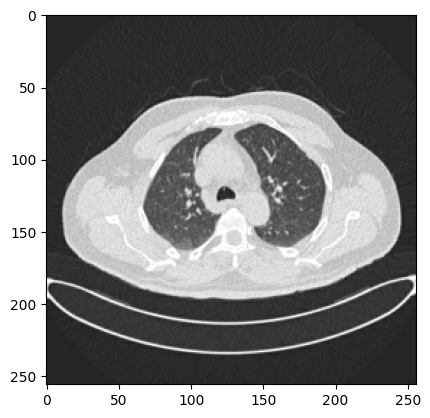

In [33]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [34]:
tf.keras.models.save_model(model,'my_model4.hdf5')


<ipython-input-34-ccff7e8ae550>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model,'my_model4.hdf5')


In [35]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 73.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.2 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0


In [39]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
from PIL import Image
import numpy as np

# Load the trained model
@st.cache(allow_output_mutation=True)
def load_model():
    model = tf.keras.models.load_model('/content/my_model4.hdf5')
    return model

# Function to preprocess and make predictions on uploaded images
def import_and_predict(image_data, model):
    # Preprocess the image
    image = Image.open(image_data)
    image = image.resize((256, 256))  # Resize to match model input size
    image = np.array(image)
    image = image / 255.0  # Normalize pixel values

    # Make prediction
    prediction = model.predict(np.expand_dims(image, axis=0))[0]

    return prediction

# Streamlit app UI
def main():
    st.title('Lung Cancer Type Prediction')

    # Upload image file
    file = st.file_uploader("Please upload a lung image", type=["jpg", "png"])

    if file is not None:
        # Display the uploaded image
        image = Image.open(file)
        st.image(image, caption='Uploaded Image.', use_column_width=True)

        # Load the model
        model = load_model()

        # Make predictions
        prediction = import_and_predict(file, model)

        # Display predictions
        if prediction[0] > 0.5:
            st.write("Prediction: Malignant")
        else:
            st.write("Prediction: Benign")

if __name__ == '__main__':
    main()


Overwriting app.py


In [40]:
!pip install pyngrok

In [ ]:
! streamlit run app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.142.138.82:8501

npx: installed 22 in 2.107s
your url is: https://gentle-turkeys-move.loca.lt
2024-03-17 09:42:42.006672: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-17 09:42:42.006724: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-17 09:42:42.008147: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-17 09:42:43.086070: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-03-17 09:43:04.202